In [1337]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from tensorflow import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model
import keras.backend as K

import model as tcav_model
import tcav as tcav
import utils as utils
import activation_generator as act_gen
import tensorflow as tf
import utils_plot as utils_plot
import cav as cav

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from numpy.linalg import norm

import pickle

from os import listdir
from os.path import isfile, join
import operator
from PIL import Image
from keras.preprocessing import image

import os
import math

import PIL.Image
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import preprocess_input

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
from scipy import stats

import tensorflow


In [3]:
K.set_learning_phase(0)
model = load_model('v3_model.h5')

/Users/tyler/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [581]:
sess = K.get_session()

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],)

tf.logging.set_verbosity(0)

working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure'

label_path = os.path.join(working_dir,'labels.txt')

mymodel = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], endpoints_v3, 
        'InceptionV3_public', (-1, 1))

# Find best average model

### gen CAV

In [116]:
concepts = [class_1,class_2]
bottleneck = layer
hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)
cav_dir = working_dir + '/cav_dir'
target_class = 'zebra'
source_dir = working_dir + '/concepts/'
activation_dir =  working_dir + '/activations/'

act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=50)

acts = act_generator.process_and_load_activations([bottleneck], concepts + [target_class])
cav_data = cav.get_or_train_cav(concepts,bottleneck,acts,cav_hparams=hparams,cav_dir=cav_dir)
this_cav = cav_data.cavs[0]

In [31]:
cav_name

'striped_sub_1-random500_0-mixed9-linear-0.1'

### Load CAV

In [106]:
class_1 = 'striped_sub_1'
class_2 = 'random500_0'
layer = 'mixed9'
lm_type = 'linear'

cav_name = class_1 + '-' + class_2 + '-' + layer + '-' + lm_type + '-0.1'
sub_path = 'cav_dir/' + cav_name 

# Load training/testing data
path = os.path.join(working_dir,sub_path + '_test.pkl')
with open(path, 'rb') as f:
    data = pickle.load(f)
    
d = dict(data)
x_train = d['x_train']
x_test = d['x_test']
y_train = d['y_train']
y_test = d['y_test']
y_pred = d['y_pred']

path = os.path.join(working_dir,sub_path + '.pkl')

with open(path, 'rb') as f:
    cav_data = pickle.load(f)
original_CAV_from_data = cav_data['cavs'][0]
original_CAV = original_CAV_from_data



In [57]:
models_dict = {}

In [47]:
#this_cav.shape

In [13]:
lm = linear_model.SGDClassifier(alpha=.1)
pca_components = pickle.load(open('pca/pca_components_mixed9.pkl', 'rb'))

In [52]:
## get original CAV
#lm.fit(x_train,y_train)
#original_CAV = -lm.coef_[0]
original_CAV = original_CAV_from_data

cavs = []

## remove one point
for idx, x_point in enumerate(x_train):
    if y_train[idx]==0:
        x_train_new = np.delete(x_train, idx, axis=0)
        y_train_new = np.delete(y_train, idx, axis=0)
        
        new_lm = linear_model.SGDClassifier(alpha=.1)
        new_lm.fit(x_train_new,y_train_new)
        cav_params = -new_lm.coef_[0]
        sim = euclidean_distance(vec_norm(cav_params),vec_norm(original_CAV))
        cosine_sim = cosine_similarity(cav_params,original_CAV)
        cavs.append([idx,cav_params,sim,cosine_sim,x_point])
        
cavs_sims = np.array([a[2] for a in cavs])
cos_sims = np.array([a[3] for a in cavs]) 

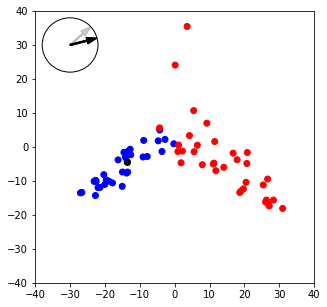

In [178]:
## Plot new
idx = 1
this_cav = cavs[idx][1]
x_point = cavs[idx][0]
x_train_new = np.delete(x_train, x_point, axis=0)
x_rem = x_train[x_point]
y_train_new = np.delete(y_train, x_point, axis=0)

x_train_embed_pca = np.dot(pca_components, x_train_new.T)
color_train_pca = ['red' if y == 0 else 'blue' for y in y_train_new]

b = np.dot(pca_components, x_rem.T)
#a = np.delete(x_train_embed_pca, x_point, axis=1)

fig = plt.figure(figsize=[5,5])
xlim = plt.xlim([-40,40])
ylim = plt.ylim([-40,40])
plt.scatter(x_train_embed_pca[0], x_train_embed_pca[1], color = color_train_pca)

plt.scatter(b[0], b[1], color = 'black')

circ = plt.Circle((-30, 30), radius=8, edgecolor='black', facecolor='None')
ax = plt.gca()
ax.add_patch(circ)
arrow_start = [-30,30]

# new cav is dark
cav_pca = np.dot(pca_components, this_cav.T)
cav_norm = vec_norm(cav_pca) * 8
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None, alpha = .8)
a0 = ax.add_patch(my_arrow)

# orig is transparent
cav_pca_1 = np.dot(pca_components, original_CAV.T)
cav_norm_1 = vec_norm(cav_pca_1) * 8
my_arrow_1 = plt.arrow(arrow_start[0], arrow_start[1], cav_norm_1[0], cav_norm_1[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None, alpha = .1)
a1 = ax.add_patch(my_arrow_1)



In [107]:
x = d['x']
y = d['y']

In [137]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state = 11)

In [138]:
x_train.shape

(67, 131072)

In [145]:
## Find TCAV score

In [228]:
class_acts = acts[target_class][bottleneck]

In [298]:
models_dict['n_10_30'] = []
lm = linear_model.SGDClassifier(alpha=.1)

num_model = 10
num_runs = 30

for i in range(num_model):
    these_c = np.zeros((num_runs,131072))
    for j in range(num_runs):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)
        lm.fit(x_train,y_train)
        these_c[j] = lm.coef_
    lm.coef_ = np.expand_dims(these_c.mean(axis = 0),axis = 0)
    y_pred = lm.predict(x_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    models_dict['n_10_30'].append([-lm.coef_,accuracy])

In [299]:
for coef,acc in models_dict['n_10_30']:
    d = round(euclidean_distance(coef,original_CAV),2)
    
    score = comp_tcav(target_class,coef.reshape(-1),class_acts,bottleneck)
    print(d,acc,score)

5.15 1.0 0.74
5.02 1.0 0.78
5.14 1.0 0.62
4.9 1.0 0.66
5.29 1.0 0.64
5.2 1.0 0.62
5.25 1.0 0.64
5.06 1.0 0.68
5.06 1.0 0.82
5.14 1.0 0.62


In [300]:
comp_tcav(target_class,original_CAV,class_acts,bottleneck)

1.0

In [296]:
## split = 0
models_dict['no_test'] = []
lm = linear_model.SGDClassifier(alpha=.1)

num_model = 10
num_runs = 1

for i in range(num_model):
    these_c = np.zeros((num_runs,131072))
    for j in range(num_runs):
        #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01, stratify=y)
        x_train, y_train = x, y
        lm.fit(x_train,y_train)
        these_c[j] = lm.coef_
    lm.coef_ = np.expand_dims(these_c.mean(axis = 0),axis = 0)
    y_pred = lm.predict(x_test)
    #accuracy = metrics.accuracy_score(y_pred, y_test)
    accuracy = None
    models_dict['no_test'].append([-lm.coef_,accuracy])

In [297]:
for coef,acc in models_dict['no_test']:
    d = round(euclidean_distance(coef,original_CAV),2)
    
    score = comp_tcav(target_class,coef.reshape(-1),class_acts,bottleneck)
    print(d,acc,score)

5.78 None 0.82
5.51 None 0.52
6.56 None 0.08
5.26 None 0.38
6.19 None 0.58
6.21 None 0.86
5.83 None 0.94
6.03 None 0.68
5.75 None 0.98
5.34 None 0.68


In [301]:
models_dict['n_10_1'] = []
lm = linear_model.SGDClassifier(alpha=.1)

num_model = 10
num_runs = 1

for i in range(num_model):
    these_c = np.zeros((num_runs,131072))
    for j in range(num_runs):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)
        lm.fit(x_train,y_train)
        these_c[j] = lm.coef_
    lm.coef_ = np.expand_dims(these_c.mean(axis = 0),axis = 0)
    y_pred = lm.predict(x_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    models_dict['n_10_1'].append([-lm.coef_,accuracy])

In [302]:
for coef,acc in models_dict['n_10_1']:
    d = round(euclidean_distance(coef,original_CAV),2)
    score = comp_tcav(target_class,coef.reshape(-1),class_acts,bottleneck)
    print(d,acc,score)

5.93 0.9696969696969697 0.88
7.33 1.0 0.16
6.4 1.0 0.7
6.6 1.0 0.66
6.13 0.9696969696969697 0.76
6.35 0.8787878787878788 0.84
6.33 1.0 0.8
7.72 0.9090909090909091 0.34
6.25 1.0 0.9
6.98 1.0 0.26


In [310]:
models_dict['n_10_1_seed'] = []
lm = linear_model.SGDClassifier(alpha=.1)

num_model = 10
num_runs = 1

for i in range(num_model):
    these_c = np.zeros((num_runs,131072))
    for j in range(num_runs):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state = 1)
        lm.fit(x_train,y_train)
        these_c[j] = lm.coef_
    lm.coef_ = np.expand_dims(these_c.mean(axis = 0),axis = 0)
    y_pred = lm.predict(x_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    models_dict['n_10_1_seed'].append([-lm.coef_,accuracy])

In [311]:
for coef,acc in models_dict['n_10_1_seed']:
    d = round(euclidean_distance(coef,original_CAV),2)
    score = comp_tcav(target_class,coef.reshape(-1),class_acts,bottleneck)
    print(d,acc,score)

6.95 0.9696969696969697 0.84
6.62 0.9696969696969697 0.56
6.86 0.9696969696969697 0.66
6.37 0.9696969696969697 0.74
6.03 0.9393939393939394 0.96
6.4 0.9696969696969697 0.58
6.69 1.0 0.22
6.13 0.9696969696969697 0.66
6.14 0.9696969696969697 0.52
6.5 0.9696969696969697 0.66


In [303]:
## center of mass for CAV
models_dict['center_of_mass'] = []
lm = linear_model.SGDClassifier(alpha=.1)

num_model = 10
num_runs = 1

for i in range(num_model):
    these_c = np.zeros((num_runs,131072))
    for j in range(num_runs):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)
        
        x_train_p_list,x_train_n_list = [],[]
        for idx,a in enumerate(x_train):
            if y_train[idx] == 0:
                x_train_p_list.append(a)
            else:
                x_train_n_list.append(a)
        x_train_p,x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)
        
        p_avg = x_train_p.mean(axis=0,keepdims=True)
        n_avg = x_train_n.mean(axis=0,keepdims=True)
        
        cav_by_mass = -(p_avg - n_avg).reshape(-1)
        #x_train, y_train = x, y
        #lm.fit(x_train,y_train)
        these_c[j] = cav_by_mass
    lm.coef_ = np.expand_dims(these_c.mean(axis = 0),axis = 0)
    #y_pred = lm.predict(x_test)
    #accuracy = metrics.accuracy_score(y_pred, y_test)
    accuracy = None
    models_dict['center_of_mass'].append([-lm.coef_,accuracy])

In [304]:
for coef,acc in models_dict['center_of_mass']:
    d = round(euclidean_distance(coef,original_CAV),2)
    score = comp_tcav(target_class,coef.reshape(-1),class_acts,bottleneck)
    print(d,acc,score)

35.06 None 0.68
34.61 None 0.5
35.36 None 0.52
35.56 None 0.66
33.36 None 0.58
36.46 None 0.56
34.71 None 0.56
34.97 None 0.62
35.81 None 0.64
34.72 None 0.54


In [322]:
models_dict.keys()

dict_keys(['no_test', 'n_10_30', 'n_10_1', 'center_of_mass', 'n_10_1_seed'])

In [323]:
list_of_cavs = models_dict['n_10_1']
#list_of_cavs = models_dict['n_10_1_seed']

list_of_cavs = models_dict['n_10_30']
#list_of_cavs = models_dict['no_test']
#list_of_cavs = models_dict['center_of_mass']

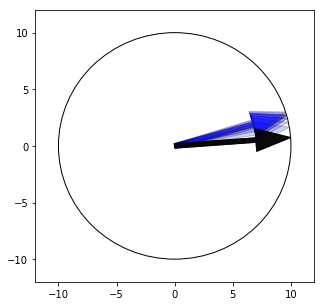

In [327]:
## Plot CAVs in loop
list_of_cavs = models_dict['n_10_30']

fig = plt.figure(figsize=[5,5])
xlim = plt.xlim([-12,12])
ylim = plt.ylim([-12,12])

radius = 10
circ = plt.Circle((0,0), radius=radius, edgecolor='black', facecolor='None')
ax = plt.gca()
ax.add_patch(circ)
arrow_start = [0,0]

# new cav is transparent, blue
for this_cav,acc in list_of_cavs:
    cav_pca = np.dot(pca_components, this_cav.reshape(-1).T)
    cav_norm = vec_norm(cav_pca) * radius
    my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                         length_includes_head=True,head_width=2,fc='b', ec=None, alpha = .1)
    a0 = ax.add_patch(my_arrow)

# orig is dark
cav_pca_1 = np.dot(pca_components, original_CAV.T)
cav_norm_1 = vec_norm(cav_pca_1) * radius
my_arrow_1 = plt.arrow(arrow_start[0], arrow_start[1], cav_norm_1[0], cav_norm_1[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None, alpha = .8)
a1 = ax.add_patch(my_arrow_1)

In [ ]:
acts_orig_array = np.zeros((len(img_paths),131072))
acts_new_array = np.zeros((len(img_paths),131072))

for i,img_path in enumerate(img_paths):
    img = prep(img_path)
    
    acts_orig = get_acts(img)
    acts_orig_array[i] = acts_orig

    #acts_final_raw = gradient_ascent_using_acts(acts_orig.reshape(1,8,8,2048),iterations=iterations,step=step,max_loss=max_loss)
    #acts_final = acts_final_raw.reshape(-1)
    #acts_new_array[i] = acts_final

    img, acts_list = gradient_ascent(img,iterations=iterations,step=step,max_loss=max_loss)
    acts_new_array[i] = get_acts(img)

## Peak to Peak

In [12]:
concept = 'striped_sub_1'

concept_dir = os.path.join(working_dir,'concepts/'+concept)
concept_image_list = files_from_dir_ext(concept_dir,'jpg')
concept_image_list.sort()

n = 131072
activations = np.zeros((len(concept_image_list),n))
for idx,image_path in enumerate(concept_image_list):
    img = prep2(os.path.join(concept_dir,image_path))
    acts_orig = get_acts(np.expand_dims(img, axis=0))
    activations[idx] = acts_orig

concept = 'random500_0'
concept_dir = os.path.join(working_dir,'concepts/'+concept)
random_image_list = files_from_dir_ext(concept_dir,'JPEG')
random_image_list.sort()

n = 131072
acts_ran = np.zeros((len(random_image_list),n))
for idx,image_path in enumerate(random_image_list):
    img = prep2(os.path.join(concept_dir,image_path))
    acts_orig = get_acts(np.expand_dims(img, axis=0))
    acts_ran[idx] = acts_orig

In [13]:
#random_image_list

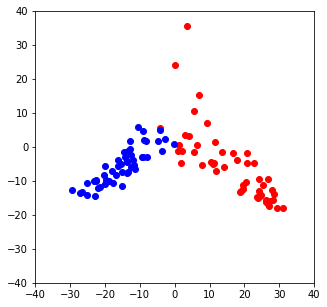

In [14]:
light_blue, light_red = '#b3b8fb', '#f6889f'
fig = plt.figure(figsize=[5,5])

# concept
embed_pca_con = np.dot(pca_components, activations.T)
plt.scatter(embed_pca_con[0], embed_pca_con[1], color = 'r')

# random
embed_pca_ran = np.dot(pca_components, acts_ran.T)
plt.scatter(embed_pca_ran[0], embed_pca_ran[1], color = 'b')

my_xlim = plt.xlim([-40,40])
my_ylim = plt.ylim([-40,40])

In [15]:
embed_pca_con.shape

(2, 50)

In [16]:
gm_con = GaussianMixture(n_components=1)
gm_ran = GaussianMixture(n_components=1)

gm_con.fit(embed_pca_con.T)
gm_ran.fit(embed_pca_ran.T)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

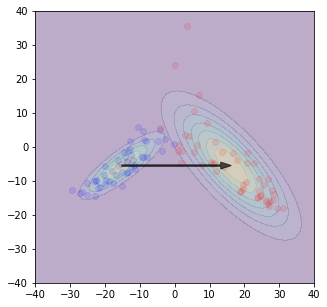

In [101]:
from matplotlib import cm

fig = plt.figure(figsize=[5,5])

N = 60
X = np.linspace(-40, 40, N)
Y = np.linspace(-40, 40, N)
X, Y = np.meshgrid(X, Y)

mu_1 = np.mean(embed_pca_con.T, axis=0)
Sigma_1 = np.cov(embed_pca_con.T, rowvar=0)

mu_2 = np.mean(embed_pca_ran.T, axis=0)
Sigma_2 = np.cov(embed_pca_ran.T, rowvar=0)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

F1 = multivariate_normal(mu_1, Sigma_1)
Z1 = F1.pdf(pos)

F2 = multivariate_normal(mu_2, Sigma_2)
Z2 = F2.pdf(pos)

ax = fig.gca()

cset = ax.contourf(X, Y, Z1, cmap=cm.viridis, alpha = .2)
cset = ax.contourf(X, Y, Z2, cmap=cm.viridis, alpha = .2)

plt.scatter(embed_pca_ran[0], embed_pca_ran[1], color = 'b', alpha = .1)
plt.scatter(embed_pca_con[0], embed_pca_con[1], color = 'r', alpha = .1)


cav = mu_1 - mu_2
arrow_start = mu_2
#my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav[0], cav[1],width=.4,length_includes_head=True,head_width=2,fc='k', ec=None, alpha = .4)
#a1 = ax.add_patch(my_arrow)


MU_1 = np.mean(activations, axis=0)
MU_2 = np.mean(acts_ran, axis=0)

MU_1_pca = np.dot(pca_components, MU_1.reshape(-1).T)
MU_2_pca = np.dot(pca_components, MU_2.reshape(-1).T)

cav = MU_1_pca - MU_2_pca

arrow_start = MU_2_pca
#my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav[0], cav[1],width=.4,length_includes_head=True,head_width=2,fc='k', ec=None, alpha = .4)
#a1 = ax.add_patch(my_arrow)


L1_p = np.linalg.norm(activations.T,1,axis = 1) / activations.shape[0]
L1_n = np.linalg.norm(acts_ran.T,1,axis = 1) / acts_ran.shape[0]
L1_cav = L1_p - L1_n

arrow_start = np.dot(pca_components, L1_n)
cav = np.dot(pca_components, L1_cav.reshape(-1).T)
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav[0], cav[1],width=.4,length_includes_head=True,head_width=2,fc='k', ec=None, alpha = .4)
a1 = ax.add_patch(my_arrow)

my_xlim = plt.xlim([-40,40])
my_ylim = plt.ylim([-40,40])

plt.show()

In [51]:
activations.mean()

MU_1 = np.mean(activations, axis=0)
MU_2 = np.mean(acts_ran, axis=0)

real_cav = MU_1 - MU_2

MU_1_pca = np.dot(pca_components, MU_1.reshape(-1).T)
MU_2_pca = np.dot(pca_components, MU_2.reshape(-1).T)

In [52]:
cav_pca = np.dot(pca_components, real_cav.reshape(-1).T)
cav_norm = vec_norm(cav_pca)

In [53]:
cav_pca

array([3.13590103e+01, 3.50234488e-03])

In [42]:
MU_1_pca = np.dot(pca_components, MU_1.reshape(-1).T)
MU_2_pca = np.dot(pca_components, MU_2.reshape(-1).T)

In [33]:
#real_cav.shape

In [20]:
gm_con = GaussianMixture(n_components=1)
gm_ran = GaussianMixture(n_components=1)

#gm_con.fit(activations)
gm_ran.fit(embed_pca_ran.T)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [22]:
embed_pca_ran.shape

(2, 50)

# L1

In [66]:
a = np.array([[5,6,7,8],
            [1,2,3,4]])

In [100]:
np.linalg.norm(a,1,axis = 1) / a.shape[1]

array([6.5, 2.5])

In [76]:
a.shape

(2, 4)

In [102]:
## Find CAV


In [121]:
def get_L1(act_for_L1):
    return np.linalg.norm(act_for_L1.T,1,axis = 1) / act_for_L1.shape[1]

In [84]:
L1_p = np.linalg.norm(activations.T,1,axis = 1) / a.shape[1]
L1_n = np.linalg.norm(acts_ran.T,1,axis = 1) / a.shape[1]
L1_cav = L1_p - L1_n

In [104]:
models_dict = {}

In [130]:
models_dict['L1_10'] = []
lm = linear_model.SGDClassifier(alpha=.1)

num_model = 10
num_runs = 1

for i in range(num_model):
    these_c = np.zeros((num_runs,131072))
    for j in range(num_runs):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)
        
        x_train_p_list,x_train_n_list = [],[]
        for idx,a in enumerate(x_train):
            if y_train[idx] == 0:
                x_train_p_list.append(a)
            else:
                x_train_n_list.append(a)
        x_train_p,x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)
        these_c[j] = get_L1(x_train_p) - get_L1(x_train_n)
        
    lm.coef_ = np.expand_dims(these_c.mean(axis = 0),axis = 0)
    accuracy = None
    models_dict['L1_10'].append([lm.coef_,accuracy])

In [131]:
target_class
for coef,acc in models_dict['L1_10']:
    d = round(euclidean_distance(coef,original_CAV),2)
    score = comp_tcav(target_class,coef.reshape(-1),class_acts,bottleneck)
    print(d,acc,score)

6.01 None 0.68
6.01 None 0.54
6.01 None 0.68
6.01 None 0.76
6.01 None 0.46
6.01 None 0.64
6.01 None 0.74
6.01 None 0.56
6.01 None 0.6
6.01 None 0.68


In [118]:
concepts = [class_1,class_2]
bottleneck = layer
hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)
cav_dir = working_dir + '/cav_dir'
target_class = 'zebra'
acts = act_generator.process_and_load_activations([bottleneck], concepts + [target_class])
class_acts = acts[target_class][bottleneck]

In [134]:
models_dict.keys()

dict_keys(['n_10_1_seed', 'L1_10'])

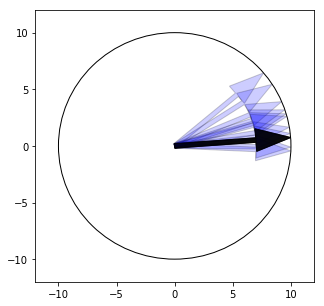

In [137]:
## Plot CAVs in loop
list_of_cavs = models_dict['n_10_1_seed']

fig = plt.figure(figsize=[5,5])
xlim = plt.xlim([-12,12])
ylim = plt.ylim([-12,12])

radius = 10
circ = plt.Circle((0,0), radius=radius, edgecolor='black', facecolor='None')
ax = plt.gca()
ax.add_patch(circ)
arrow_start = [0,0]

# new cav is transparent, blue
for this_cav,acc in list_of_cavs:
    cav_pca = np.dot(pca_components, this_cav.reshape(-1).T)
    cav_norm = vec_norm(cav_pca) * radius
    my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                         length_includes_head=True,head_width=2,fc='b', ec=None, alpha = .1)
    a0 = ax.add_patch(my_arrow)

# orig is dark
cav_pca_1 = np.dot(pca_components, original_CAV.T)
cav_norm_1 = vec_norm(cav_pca_1) * radius
my_arrow_1 = plt.arrow(arrow_start[0], arrow_start[1], cav_norm_1[0], cav_norm_1[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None, alpha = .8)
a1 = ax.add_patch(my_arrow_1)

## Test L1 on Mixed9

In [138]:
concept = 'striped_sub_1'

concept_dir = os.path.join(working_dir,'concepts/'+concept)
concept_image_list = files_from_dir_ext(concept_dir,'jpg')
concept_image_list.sort()

n = 131072
activations = np.zeros((len(concept_image_list),n))
for idx,image_path in enumerate(concept_image_list):
    img = prep2(os.path.join(concept_dir,image_path))
    acts_orig = get_acts(np.expand_dims(img, axis=0))
    activations[idx] = acts_orig

concept = 'random500_0'
concept_dir = os.path.join(working_dir,'concepts/'+concept)
random_image_list = files_from_dir_ext(concept_dir,'JPEG')
random_image_list.sort()

n = 131072
acts_ran = np.zeros((len(random_image_list),n))
for idx,image_path in enumerate(random_image_list):
    img = prep2(os.path.join(concept_dir,image_path))
    acts_orig = get_acts(np.expand_dims(img, axis=0))
    acts_ran[idx] = acts_orig
    
## save acts

In [140]:
acts_ran.shape

(50, 131072)

In [154]:
x = np.concatenate((activations,acts_ran))
y = np.concatenate((np.zeros(50),np.ones(50)))

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)

In [157]:
#model_test = {}
results = {}

In [170]:
model_test['L1'] = []
model_test['std'] = []

lm = linear_model.SGDClassifier(alpha=.1)

num_model = 100
num_runs = 1

for i in range(num_model):
    these_c = np.zeros((num_runs,131072))
    for j in range(num_runs):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)
        
        x_train_p_list,x_train_n_list = [],[]
        for idx,a in enumerate(x_train):
            if y_train[idx] == 0:
                x_train_p_list.append(a)
            else:
                x_train_n_list.append(a)
        x_train_p,x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)
        these_c[j] = get_L1(x_train_p) - get_L1(x_train_n)
        
    lm.coef_ = np.expand_dims(these_c.mean(axis = 0),axis = 0)
    accuracy = None
    model_test['L1'].append([lm.coef_,accuracy])

for i in range(num_model):
    these_c = np.zeros((num_runs,131072))
    for j in range(num_runs):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)
        lm.fit(x_train,y_train)
        these_c[j] = lm.coef_
    lm.coef_ = np.expand_dims(these_c.mean(axis = 0),axis = 0)
    y_pred = lm.predict(x_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    model_test['std'].append([-lm.coef_,accuracy])

In [171]:
results['L1'] = []
for coef,acc in model_test['L1']:
    score = comp_tcav(target_class,coef.reshape(-1),class_acts,bottleneck)
    results['L1'].append(score)

results['std'] = []
for coef,acc in model_test['std']:
    score = comp_tcav(target_class,coef.reshape(-1),class_acts,bottleneck)
    results['std'].append(score)

In [172]:
np.array(results['L1']).mean(),np.array(results['L1']).var()

(0.5972000000000001, 0.011088159999999998)

In [173]:
np.array(results['std']).mean(),np.array(results['std']).var()

(0.616, 0.06337599999999999)

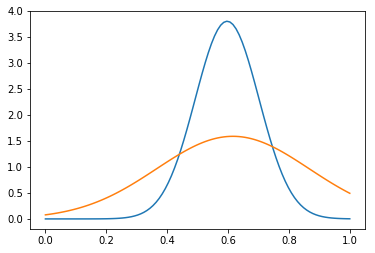

In [180]:
mu = .597
variance = .011
sigma = math.sqrt(variance)
x = np.linspace(0,1, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))

mu = .616
variance = .063
sigma = math.sqrt(variance)
x = np.linspace(0,1, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.show()

In [178]:
#results['std']

## Recover Hyperplane

In [290]:
c1 = model_test['std'][1][0]
c2 = model_test['L1'][1][0]

In [291]:
c2.shape

(1, 131072)

In [292]:
lm.coef_ = -c2
lm.intercept_ = np.array([0])
#lm.coef_ = -c1

In [298]:
np.dot(lm.coef_,x_test[0])

array([-0.19500707])

In [293]:
y_pred = lm.predict(x_test)
accuracy = metrics.accuracy_score(y_pred, y_test)
print(accuracy)

1.0


In [294]:
lm.decision_function(x_test)

array([-0.19500707, -0.12821534, -0.25378711, -0.25886894,  0.00983741,
       -0.02909258, -0.20908766, -0.23388604,  0.11092905,  0.24280813,
        0.21533899, -0.24325414, -0.09137111, -0.13284176, -0.24964479,
        0.15732819, -0.08463953,  0.18991081,  0.19528924, -0.02891493,
        0.26921717,  0.15779016,  0.11785557, -0.19380926,  0.19532396,
        0.16532376,  0.08595873, -0.03514877,  0.13964887,  0.24997353,
        0.20864605, -0.12107742, -0.21411183])

In [295]:
lm.intercept_

array([0])

## Toy Example

In [1227]:
mu_1 = np.array([-4,-4])
sigma_1 = np.array([[3,1],[1,3]])

mu_2 = np.array([2,2])
sigma_2 = np.array([[3,2],[2,3]])

In [1258]:
n = 50
g1 = multivariate_normal(mu_1, sigma_1)
z1 = g1.rvs(n)
g2 = multivariate_normal(mu_2, sigma_2)
z2 = g2.rvs(n)

In [1259]:
x = np.concatenate((z1,z2))
y = np.concatenate((np.zeros(n),np.ones(n)))

from sklearn.svm import SVC
svc = SVC(kernel = 'linear')

lm = linear_model.SGDClassifier(alpha=.1)
lm = SVC(kernel = 'linear')

In [1302]:
#training = (x,y)
#pickle.dump(training,open('training.pkl','wb'))

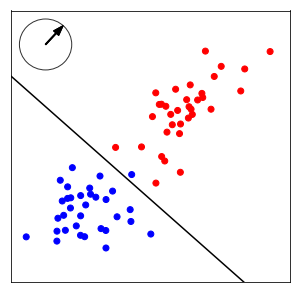

In [1325]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state=3)
lm.fit(x_train,y_train)
svc.fit(x_train,y_train)
this_cav = lm.coef_[0]

light_blue, light_red = '#b3b8fb', '#f6889f'
fig = plt.figure(figsize=[5,5])

# train
#plt.scatter(z1[:,0], z1[:,1], color = 'r') #plt.scatter(z2[:,0], z2[:,1], color = 'b')
color_train = ['red' if y == 1 else 'blue' for y in y_train]
plt.scatter(x_train[:,0], x_train[:,1], color = color_train)

# test
#color_test = [light_red if y == 0 else light_blue for y in y_test]
#plt.scatter(x_test[:,0], x_test[:,1], color = color_test)

ax = plt.gca()
radius = 1.5
circ = plt.Circle((-6,6), radius=radius, edgecolor='black', facecolor='white',zorder=4,alpha=.8)
ax.add_patch(circ)

arrow_start = [-6,6]
cav_norm = vec_norm(this_cav) * radius
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.05,length_includes_head=True,head_width=.4,fc='k', ec=None, alpha = 1,zorder=5)
a0 = ax.add_patch(my_arrow)

c0,c1 = lm.coef_[0]
b = lm.intercept_
x_ = np.linspace(-10,10,100)
y_ = (-c0/c1)*x_-b/c1
plt.plot(x_, y_, 'k')

my_xlim = plt.xlim([-8,8])
my_ylim = plt.ylim([-8,8])

_,_ = plt.xticks([], []),plt.yticks([], [])
plt.savefig('new_figs/svm_2.png',dpi=200)

In [1261]:
svc.support_

array([ 9, 64,  4, 27], dtype=int32)

In [1262]:
svc.n_support_

array([2, 2], dtype=int32)

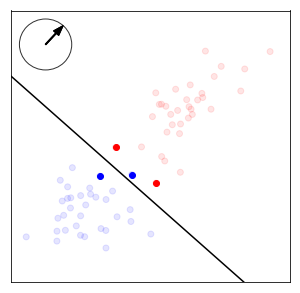

In [1324]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state=3)
lm.fit(x_train,y_train)
svc.fit(x_train,y_train)
this_cav = lm.coef_[0]

light_blue, light_red = '#b3b8fb', '#f6889f'
fig = plt.figure(figsize=[5,5])

# train
#plt.scatter(z1[:,0], z1[:,1], color = 'r') #plt.scatter(z2[:,0], z2[:,1], color = 'b')
color_train = ['red' if y == 1 else 'blue' for y in y_train]
plt.scatter(x_train[:,0], x_train[:,1], color = color_train, alpha = .1)

for s in svc.support_:
    if y_train[s]==1:
        this_color = 'red'
    else:
        this_color = 'blue'
    plt.scatter(x_train[s,0], x_train[s,1], color = this_color)#,edgecolor='black' )


# test
#color_test = [light_red if y == 0 else light_blue for y in y_test]
#plt.scatter(x_test[:,0], x_test[:,1], color = color_test)

ax = plt.gca()
radius = 1.5
circ = plt.Circle((-6,6), radius=radius, edgecolor='black', facecolor='white',zorder=4,alpha=.8)
ax.add_patch(circ)

arrow_start = [-6,6]
cav_norm = vec_norm(this_cav) * radius
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.05,length_includes_head=True,head_width=.4,fc='k', ec=None, alpha = 1,zorder=5)
a0 = ax.add_patch(my_arrow)

c0,c1 = lm.coef_[0]
b = lm.intercept_
x_ = np.linspace(-10,10,100)
y_ = (-c0/c1)*x_-b/c1
plt.plot(x_, y_, 'k')

my_xlim = plt.xlim([-8,8])
my_ylim = plt.ylim([-8,8])

_,_ = plt.xticks([], []),plt.yticks([], [])
plt.savefig('new_figs/svm_1.png',dpi=200)

In [1264]:
toy_cavs = []
original_CAV = this_cav

for idx, x_point in enumerate(x_train):
    if y_train[idx]==1:
        x_train_new = np.delete(x_train, idx, axis=0)
        y_train_new = np.delete(y_train, idx, axis=0)
        
        #new_lm = linear_model.SGDClassifier(alpha=.1)
        new_svc = SVC(kernel = 'linear')
        
        new_svc.fit(x_train_new,y_train_new)
        
        cav_params = -new_svc.coef_[0]
        
        sim = euclidean_distance(vec_norm(cav_params),vec_norm(original_CAV))
        cosine_sim = cosine_similarity(cav_params,original_CAV)
        toy_cavs.append([idx,new_svc,sim,cosine_sim,x_point])
        
cavs_sims = np.array([a[2] for a in toy_cavs])
cos_sims = np.array([a[3] for a in toy_cavs]) 

In [1265]:
#toy_cavs

In [1266]:
toy_cavs[1]

[2, SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='linear', max_iter=-1, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False), 2.0, -1.0, array([4.07236126, 4.71212283])]

In [1267]:
cos_sims.argmax()

14

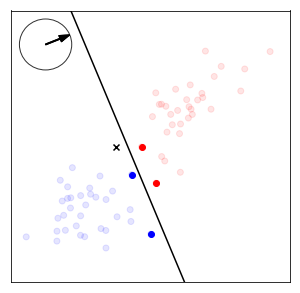

In [1298]:
i = 14
this_svm = toy_cavs[i][1]

idx = toy_cavs[i][0]
this_cav = this_svm.coef_[0]

x_train_new = np.delete(x_train, idx, axis=0)
y_train_new = np.delete(y_train, idx, axis=0)

light_blue, light_red = '#b3b8fb', '#f6889f'
fig = plt.figure(figsize=[5,5])

# train
color_train = ['red' if y == 1 else 'blue' for y in y_train_new]
plt.scatter(x_train_new[:,0], x_train_new[:,1], color = color_train, alpha = .1)

plt.scatter(x_train[idx,0], x_train[idx,1], color = 'k', alpha = 1, marker='x')

for s in this_svm.support_:
    if y_train_new[s]==1:
        this_color = 'red'
    else:
        this_color = 'blue'
    plt.scatter(x_train_new[s,0], x_train_new[s,1], color = this_color)#,edgecolor='black' )


# test
#color_test = [light_red if y == 0 else light_blue for y in y_test]
#plt.scatter(x_test[:,0], x_test[:,1], color = color_test)

ax = plt.gca()
radius = 1.5
circ = plt.Circle((-6,6), radius=radius, edgecolor='black', facecolor='white',zorder=4,alpha=.8)
ax.add_patch(circ)

arrow_start = [-6,6]
cav_norm = vec_norm(this_cav) * radius
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.05,length_includes_head=True,head_width=.4,fc='k', ec=None, alpha = 1,zorder=5)
a0 = ax.add_patch(my_arrow)

c0,c1 = this_svm.coef_[0]
b = this_svm.intercept_
x_ = np.linspace(-10,10,100)
y_ = (-c0/c1)*x_-b/c1
plt.plot(x_, y_, 'k')

my_xlim = plt.xlim([-8,8])
my_ylim = plt.ylim([-8,8])

_,_ = plt.xticks([], []),plt.yticks([], [])
plt.savefig('new_figs/svm_0.png',dpi=200)

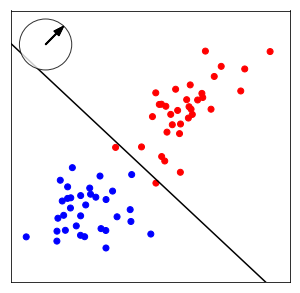

In [1328]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state=3)

x_train_p_list,x_train_n_list =[],[]
for idx,a in enumerate(x_train):
    if y_train[idx] == 1:
        x_train_p_list.append(a)
    else:
        x_train_n_list.append(a)

x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

mu_p = (x_train_p).mean(axis=0)
mu_n = (x_train_n).mean(axis=0)

this_cav =  mu_p - mu_n

light_blue, light_red = '#b3b8fb', '#f6889f'
fig = plt.figure(figsize=[5,5])

# train
color_train = ['red' if y == 1 else 'blue' for y in y_train]
plt.scatter(x_train[:,0], x_train[:,1], color = color_train)

ax = plt.gca()
radius = 1.5
circ = plt.Circle((-6,6), radius=radius, edgecolor='black', facecolor='white',zorder=4,alpha=.8)
ax.add_patch(circ)

arrow_start = [-6,6]
cav_norm = vec_norm(this_cav) * radius
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.05,length_includes_head=True,head_width=.4,fc='k', ec=None, alpha = 1,zorder=5)
a0 = ax.add_patch(my_arrow)

c0,c1 = this_cav[0],this_cav[1]
b = -.5 * (np.dot(mu_p,mu_p.T) - np.dot(mu_n,mu_n.T))
x_ = np.linspace(-10,10,100)
y_ = (-c0/c1)*x_-b/c1
plt.plot(x_, y_, 'k')

my_xlim = plt.xlim([-8,8])
my_ylim = plt.ylim([-8,8])

_,_ = plt.xticks([], []),plt.yticks([], [])
#plt.savefig('new_figs/svm_2.png',dpi=200)

In [1329]:
cav_1 = this_cav

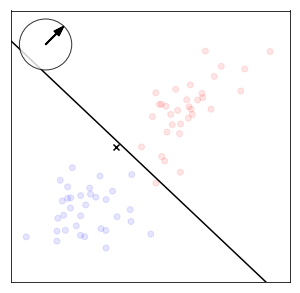

In [1330]:
i = 14

idx = toy_cavs[i][0]

x_train_new = np.delete(x_train, idx, axis=0)
y_train_new = np.delete(y_train, idx, axis=0)

light_blue, light_red = '#b3b8fb', '#f6889f'

fig = plt.figure(figsize=[5,5])

# train
color_train = ['red' if y == 1 else 'blue' for y in y_train_new]
plt.scatter(x_train_new[:,0], x_train_new[:,1], color = color_train, alpha = .1)
plt.scatter(x_train[idx,0], x_train[idx,1], color = 'k', alpha = 1, marker='x')

x_train_p_list,x_train_n_list =[],[]
for idx,a in enumerate(x_train_new):
    if y_train_new[idx] == 1:
        x_train_p_list.append(a)
    else:
        x_train_n_list.append(a)

x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

mu_p = (x_train_p).mean(axis=0)
mu_n = (x_train_n).mean(axis=0)

this_cav =  mu_p - mu_n

ax = plt.gca()
radius = 1.5
circ = plt.Circle((-6,6), radius=radius, edgecolor='black', facecolor='white',zorder=4,alpha=.8)
ax.add_patch(circ)

arrow_start = [-6,6]
cav_norm = vec_norm(this_cav) * radius
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.05,length_includes_head=True,head_width=.4,fc='k', ec=None, alpha = 1,zorder=5)
a0 = ax.add_patch(my_arrow)

c0,c1 = this_cav[0],this_cav[1]
b = -.5 * (np.dot(mu_p,mu_p.T) - np.dot(mu_n,mu_n.T))
x_ = np.linspace(-10,10,100)
y_ = (-c0/c1)*x_-b/c1
plt.plot(x_, y_, 'k')

my_xlim = plt.xlim([-8,8])
my_ylim = plt.ylim([-8,8])

_,_ = plt.xticks([], []),plt.yticks([], [])
#plt.savefig('new_figs/svm_2.png',dpi=200)


In [1331]:
cav_2 = this_cav

In [1332]:
cav_1,cav_2

(array([5.64007918, 5.86689124]), array([5.76045144, 5.93265522]))

In [1319]:
-.5 * (np.dot(mu_p,mu_p.T) - np.dot(mu_n,mu_n.T))

9.521377739744988

In [1315]:
np.linalg.norm(mu_p)

2.8993154161136574

In [1317]:
np.dot(mu_p,mu_p.T)

8.40602988211431

In [848]:
## lots of CAVs
this_list = []
for i in range(50):
    n = 50
    g1 = multivariate_normal(mu_1, sigma_1)
    z1 = g1.rvs(n)
    g2 = multivariate_normal(mu_2, sigma_2)
    z2 = g2.rvs(n)

    x = np.concatenate((z1,z2))
    y = np.concatenate((np.zeros(n),np.ones(n)))
    lm = linear_model.SGDClassifier(alpha=.1)
    lm.fit(x,y)
    this_cav = lm.coef_[0]
    this_list.append(this_cav)

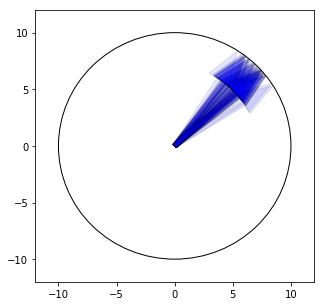

In [849]:
## Plot CAVs in loop
list_of_cavs = this_list

fig = plt.figure(figsize=[5,5])
xlim = plt.xlim([-12,12])
ylim = plt.ylim([-12,12])

radius = 10
circ = plt.Circle((0,0), radius=radius, edgecolor='black', facecolor='None')
ax = plt.gca()
ax.add_patch(circ)
arrow_start = [0,0]

# new cav is transparent, blue
for this_cav in list_of_cavs:
    cav_norm = vec_norm(this_cav) * radius
    my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                         length_includes_head=True,head_width=2,fc='b', ec=None, alpha = .05)
    a0 = ax.add_patch(my_arrow)


In [850]:
## Remove the most influenctial point

In [853]:
toy_cavs = []
lm.fit()

for idx, x_point in enumerate(x_train):
    if y_train[idx]==0:
        x_train_new = np.delete(x_train, idx, axis=0)
        y_train_new = np.delete(y_train, idx, axis=0)
        
        new_lm = linear_model.SGDClassifier(alpha=.1)
        new_lm.fit(x_train_new,y_train_new)
        cav_params = -new_lm.coef_[0]
        sim = euclidean_distance(vec_norm(cav_params),vec_norm(original_CAV))
        cosine_sim = cosine_similarity(cav_params,original_CAV)
        toy_cavs.append([idx,cav_params,sim,cosine_sim,x_point])
        
cavs_sims = np.array([a[2] for a in toy_cavs])
cos_sims = np.array([a[3] for a in toy_cavs]) 

In [ ]:
## What do grads do?

In [1362]:
#model.layers

In [1410]:
#for idx,l in enumerate(model.layers):
#    print(idx,l.name)

In [1377]:
## first_part
tf.logging.set_verbosity(0)
# 279 = mixed9
# 196 = mixed6
to_concat = model.layers[196]
to_concat.get_input_at(0)
concat = model.layers[197]
concat.get_input_at(0)

first_part_endpoints = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=to_concat.output[0].name,
    prediction=to_concat.output[0].name,
    prediction_tensor=to_concat.output[0],)

first_part_model = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], first_part_endpoints, 
        'InceptionV3_public', (-1, 1))

## second_part
second_part_endpoints = dict(
    input=concat.name,
    input_tensor=concat.input,
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],)

second_part_model = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], second_part_endpoints, 
        'InceptionV3_public', (-1, 1))

In [1378]:
## load CAV
class_1 = 'striped_sub_1'
class_2 = 'random500_0'
layer = 'mixed6'
lm_type = 'linear'

cav_name = class_1 + '-' + class_2 + '-' + layer + '-' + lm_type + '-0.1'
sub_path = 'cav_dir/' + cav_name + '.pkl'

path = os.path.join(working_dir, sub_path)
this_cav = cav.CAV.load_cav(path)

In [1404]:
# perturb
base_image_path = os.path.join(working_dir,'concepts/zebra/img36.jpg')

my_list = []
for c in concept_image_list:
    base_image_path = os.path.join(working_dir,'concepts/zebra/'+c)
    img = image.load_img(base_image_path, target_size=(299, 299))
    img_array = np.array(img)
    img_new_dims = np.expand_dims(img_array, axis=0)
    img_input = preprocess_input(img_new_dims)

    pred_1 = first_part_model.get_predictions(img_input)
    pred_1 = np.expand_dims(pred_1, axis=0)

    this_dir = get_dir_from_pert(pred_1)
    #print(this_dir)
    my_list.append(this_dir)

In [1405]:
arr = np.array(my_list)

In [1409]:
(arr > 0).sum() / (arr > 0).shape[0]

0.86

In [1355]:
pred_1_pert = this_cav.perturb_act(pred_1,to_concept,alpha = a)

In [1394]:
#concept_dir = 
concept_image_list = files_from_dir_ext(concept_dir,'jpg')
concept_image_list.sort()

In [1357]:
#pred_1_pert

In [1402]:
def get_dir_from_pert(pred_1):
    a = 0
    pred_2 = second_part_model.get_predictions(pred_1)
    decoded = decode_predictions(pred_2, top=1000)
    p1 = get_p(decoded,'zebra')

    a = .01
    to_concept = 'striped_sub_1'
    pred_1_pert = this_cav.perturb_act(pred_1,to_concept,alpha = a)
    pred_2 = second_part_model.get_predictions(pred_1_pert)
    decoded = decode_predictions(pred_2, top=1000)
    p2 = get_p(decoded,'zebra')

    return (p2-p1) / a


In [1343]:
def get_p(decoded,class_name):
    for d in decoded[0]:
        if d[1] ==class_name:
            z = d[2]
    if z:
        return z

In [297]:
#explained_variance_ratio_

## Functions

In [699]:
## define functions
pca_components = pickle.load(open('pca/pca_components_mixed9.pkl', 'rb'))


def vector_norm(vec):
    norm_const = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
    return vec / norm_const

def vec_norm(vec):
    return  vec / np.linalg.norm(vec)

## CAV distance
def euclidean_distance(a,b):
    return np.linalg.norm(a-b)

def cosine_similarity(v1,v2):
    # compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy / math.sqrt(sumxx*sumyy)

def files_from_dir(a_dir):
    onlyfiles = [f for f in os.listdir(a_dir) if os.path.isfile(os.path.join(a_dir, f))]
    return onlyfiles

def files_from_dir_ext(a_dir,ext):
    onlyfiles = [f for f in os.listdir(a_dir) if os.path.isfile(os.path.join(a_dir, f))]
    this_ext = [e for e in onlyfiles if ext in e.lower()]
    return this_ext

def prep2(filename):
    shape=(299, 299)
    img = np.array(PIL.Image.open(open(filename, 'rb')).convert('RGB').resize(shape, PIL.Image.BILINEAR))
    # Normalize pixel values to between 0 and 1.
    img = np.float32(img) / 255.0
    if not (len(img.shape) == 3 and img.shape[2] == 3):
        return None
    else:
        return img
    
layer_dict = dict([(layer.name, layer) for layer in model.layers])
sess = K.get_session()

layer_name = 'mixed9'

these_acts = layer_dict[layer_name].output
get_acts_func = K.function([model.input],[these_acts])

#name_ph = K.placeholder(dtype='string')
#these_acts_for_layer = layer_dict[name_ph].output
#get_acts_for_layer_func = K.function([name_ph,model.input],[these_acts_for_layer])

def get_acts(input_img):
    outs = get_acts_func([input_img])
    acts_value = outs[0]
    return acts_value.reshape(-1)

def get_acts_for_layer(layer_name,input_img):
    acts_value = layer_dict[layer_name].output
    outs = get_acts_for_layer_func([layer_name,input_img])
    acts_value = outs[0]
    return acts_value.reshape(-1)


acts_mixed0_f = K.function([model.input],[layer_dict['mixed0'].output])
acts_mixed1_f = K.function([model.input],[layer_dict['mixed1'].output])
acts_mixed2_f = K.function([model.input],[layer_dict['mixed2'].output])
acts_mixed3_f = K.function([model.input],[layer_dict['mixed3'].output])
acts_mixed4_f = K.function([model.input],[layer_dict['mixed4'].output])
acts_mixed5_f = K.function([model.input],[layer_dict['mixed5'].output])
acts_mixed6_f = K.function([model.input],[layer_dict['mixed6'].output])
acts_mixed7_f = K.function([model.input],[layer_dict['mixed7'].output])
acts_mixed8_f = K.function([model.input],[layer_dict['mixed8'].output])
acts_mixed9_f = K.function([model.input],[layer_dict['mixed9'].output])
acts_mixed10_f = K.function([model.input],[layer_dict['mixed10'].output])

def get_acts_for_layer_new(layer_name,input_img):
    acts = None
    if layer_name=='mixed0':
        acts = acts_mixed0_f([input_img])[0]
    if layer_name=='mixed1':
        acts = acts_mixed1_f([input_img])[0]
    if layer_name=='mixed2':
        acts = acts_mixed2_f([input_img])[0]
    if layer_name=='mixed3':
        acts = acts_mixed3_f([input_img])[0]
    if layer_name=='mixed4':
        acts = acts_mixed4_f([input_img])[0]
    if layer_name=='mixed5':
        acts = acts_mixed5_f([input_img])[0]
    if layer_name=='mixed6':
        acts = acts_mixed6_f([input_img])[0]
    if layer_name=='mixed7':
        acts = acts_mixed7_f([input_img])[0]
    if layer_name=='mixed8':
        acts = acts_mixed8_f([input_img])[0]
    if layer_name=='mixed9':
        acts = acts_mixed9_f([input_img])[0]
    if layer_name=='mixed10':
        acts = acts_mixed10_f([input_img])[0]
    
    return acts


bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9','mixed10']

size_dict = {}
for bn in bn_names:
    acts_orig = get_acts_for_layer_new(bn,this_img)
    size_dict[bn] = acts_orig.reshape(-1).shape[0]
    
size_dict_orig = {}
for bn in bn_names:
    acts_orig = get_acts_for_layer_new(bn,this_img)
    size_dict_orig[bn] = acts_orig.shape

In [1412]:
size_dict_orig

{'mixed0': (1, 35, 35, 256),
 'mixed1': (1, 35, 35, 288),
 'mixed2': (1, 35, 35, 288),
 'mixed3': (1, 17, 17, 768),
 'mixed4': (1, 17, 17, 768),
 'mixed5': (1, 17, 17, 768),
 'mixed6': (1, 17, 17, 768),
 'mixed7': (1, 17, 17, 768),
 'mixed8': (1, 8, 8, 1280),
 'mixed9': (1, 8, 8, 2048),
 'mixed10': (1, 8, 8, 2048)}

In [701]:
#size_dict_orig

In [560]:
#size_dict['mixed3']

In [532]:
acts_orig = get_acts_for_layer('mixed0',this_img)

In [540]:
acts_orig.reshape(-1).shape[0]

131072

In [1456]:
## get activations for concept, layer


def get_acts_for_concept(concept,layer):
    concept_dir = os.path.join(working_dir,'concepts/'+concept)
    image_list = files_from_dir_ext(concept_dir,'jp')
    image_list.sort()

    act_path = os.path.join(working_dir,'final_acts/' + concept + '-' + layer + '.pkl')

    n = size_dict[layer]
    nn = size_dict_orig[layer]

    try:
        this_dict = pickle.load(open(act_path, 'rb'))
    except:
        this_dict = {}
        
    #print(nn)
    
    acts_ran = np.zeros((len(image_list),n))
    orig = np.zeros((len(image_list),nn[1],nn[2],nn[3]))
    
    for idx,image_path in enumerate(image_list):
        if image_path not in this_dict:
            img = prep2(os.path.join(concept_dir,image_path))
            this_img = np.expand_dims(img, axis=0)
            acts_orig = get_acts_for_layer_new(layer,this_img)
            acts_ran[idx] = acts_orig.reshape(-1)
            orig[idx] = acts_orig
            this_dict[image_path] = (acts_orig.reshape(-1),acts_orig)
        else:
            acts_ran[idx],orig[idx] = this_dict[image_path]
            #print('acts already exist')

    pickle.dump(this_dict,open(act_path, 'wb'))
    
    return acts_ran,orig

def make_orig_cav(x_train,y_train):
    lm = linear_model.SGDClassifier(alpha=.1)
    lm.fit(x_train, y_train)
    this_cav = -lm.coef_[0]
    return this_cav

def make_L1_cav(x_train,y_train):
    x_train_p_list,x_train_n_list =[],[]
    for idx,a in enumerate(x_train):
        if y_train[idx] == 0:
            x_train_p_list.append(a)
        else:
            x_train_n_list.append(a)

    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)
    L1_cav = get_L1(x_train_p) - get_L1(x_train_n)
    return L1_cav


In [716]:
acts_ran = np.zeros((len(image_list),n))

In [717]:
acts_ran.shape

(50, 221952)

In [710]:
get_acts_for_layer_new(layer,this_img).shape

(1, 8, 8, 2048)

In [720]:
concept = 'zebra'
layer = 'mixed9'
my_acts = get_acts_for_concept(concept,layer)

(1, 8, 8, 2048)


In [690]:
orig = np.zeros((len(image_list),nn[1],nn[2],nn[3]))

In [692]:
orig.shape

(50, 17, 17, 768)

In [601]:
acts_class

In [664]:
## Make CAV
layer = 'mixed3'

my_class = 'zebra_50'
concept_p,concept_n = 'striped_sub_1','random500_0'
acts_p,_ = get_acts_for_concept(concept_p,layer)
acts_n,_ = get_acts_for_concept(concept_n,layer)
_,acts_class = get_acts_for_concept(my_class,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(50),np.ones(50)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)

cav_1 = make_orig_cav(x_train,y_train)
score_1 = comp_tcav(target_class,cav_1,acts_class,layer)

cav_L1 = make_L1_cav(x_train,y_train)
score_2 = comp_tcav(target_class,L1_cav,acts_class,layer)

print(score_1,score_2)


0.6 0.58


In [757]:
columns = ['target_class','layer','concept_p','concept_n','orig_score','L1_score']
df = pd.DataFrame(columns = columns)

In [758]:
pickle.dump(df,open('df.pkl', 'wb'))

In [1026]:
## CAV loop
source_dir = working_dir + '/concepts/'

target_class = 'zebra'
class_1 = 'striped_sub_1'

class_1_list = ['random500_21']#,'dotted_sub_1']

hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)

bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9','mixed10']
#bn_names = ['mixed0','mixed1','mixed2']

df = pickle.load(open('df.pkl', 'rb'))

for concept_p in class_1_list:
    for layer in  bn_names:
        for class_idx in range(20):
            concept_n = 'random500_' + str(class_idx)
            if len(df[(df['target_class']==target_class) & 
                    (df['layer']==layer) & 
                    (df['concept_p']==concept_p) &
                    (df['concept_n']==concept_n)]) == 0:
                print(f'running {target_class}, {layer}, {concept_p}, {concept_n}')
                
                acts_p,_ = get_acts_for_concept(concept_p,layer)
                acts_n,_ = get_acts_for_concept(concept_n,layer)
                _,acts_class = get_acts_for_concept(target_class,layer)
                #print(acts_class.shape)
                x = np.concatenate((acts_p,acts_n))
                y = np.concatenate((np.zeros(50),np.ones(50)))

                x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)

                
                cav_1 = make_orig_cav(x_train,y_train)
                score_1 = comp_tcav(target_class,cav_1,acts_class,layer)

                cav_L1 = make_L1_cav(x_train,y_train)
                score_2 = comp_tcav(target_class,cav_L1,acts_class,layer)

                this_dict = {'target_class':target_class,
                             'layer':layer,
                             'concept_p':concept_p,
                             'concept_n':concept_n,
                             'orig_score':score_1,
                             'L1_score':score_2,
                            }
                df = df.append([this_dict])
            else:
                print(f'already in df {target_class}, {layer}, {concept_p}, {concept_n}')
            
pickle.dump(df,open('df.pkl', 'wb'))
print('### did write ###')

running zebra, mixed0, random500_21, random500_0
running zebra, mixed0, random500_21, random500_1
running zebra, mixed0, random500_21, random500_2
running zebra, mixed0, random500_21, random500_3
running zebra, mixed0, random500_21, random500_4
running zebra, mixed0, random500_21, random500_5
running zebra, mixed0, random500_21, random500_6
running zebra, mixed0, random500_21, random500_7
running zebra, mixed0, random500_21, random500_8
running zebra, mixed0, random500_21, random500_9
running zebra, mixed0, random500_21, random500_10
running zebra, mixed0, random500_21, random500_11
running zebra, mixed0, random500_21, random500_12
running zebra, mixed0, random500_21, random500_13
running zebra, mixed0, random500_21, random500_14
running zebra, mixed0, random500_21, random500_15
running zebra, mixed0, random500_21, random500_16
running zebra, mixed0, random500_21, random500_17
running zebra, mixed0, random500_21, random500_18
running zebra, mixed0, random500_21, random500_19
running ze

running zebra, mixed8, random500_21, random500_6
running zebra, mixed8, random500_21, random500_7
running zebra, mixed8, random500_21, random500_8
running zebra, mixed8, random500_21, random500_9
running zebra, mixed8, random500_21, random500_10
running zebra, mixed8, random500_21, random500_11
running zebra, mixed8, random500_21, random500_12
running zebra, mixed8, random500_21, random500_13
running zebra, mixed8, random500_21, random500_14
running zebra, mixed8, random500_21, random500_15
running zebra, mixed8, random500_21, random500_16
running zebra, mixed8, random500_21, random500_17
running zebra, mixed8, random500_21, random500_18
running zebra, mixed8, random500_21, random500_19
running zebra, mixed9, random500_21, random500_0
running zebra, mixed9, random500_21, random500_1
running zebra, mixed9, random500_21, random500_2
running zebra, mixed9, random500_21, random500_3
running zebra, mixed9, random500_21, random500_4
running zebra, mixed9, random500_21, random500_5
running ze

In [831]:
target_class = 'zebra'
layer = 'mixed8'
concept_p = 'striped_sub_1'

subset = df[(df['target_class']==target_class) & 
                (df['layer']==layer) & 
                (df['concept_p']==concept_p)]

In [832]:
subset['orig_score'].mean(),subset['orig_score'].var()

(0.7089999999999999, 0.024019999999999996)

In [833]:
subset['L1_score'].mean(),subset['L1_score'].var()

(0.684, 0.0022147368421052624)

In [838]:
size_dict

{'mixed0': 313600,
 'mixed1': 352800,
 'mixed2': 352800,
 'mixed3': 221952,
 'mixed4': 221952,
 'mixed5': 221952,
 'mixed6': 221952,
 'mixed7': 221952,
 'mixed8': 81920,
 'mixed9': 131072,
 'mixed10': 131072}

In [834]:
subset

,target_class,layer,concept_p,concept_n,orig_score,L1_score
0,zebra,mixed8,striped_sub_1,random500_0,0.38,0.68
0,zebra,mixed8,striped_sub_1,random500_1,0.66,0.68
0,zebra,mixed8,striped_sub_1,random500_2,0.70,0.72
0,zebra,mixed8,striped_sub_1,random500_3,0.82,0.68
0,zebra,mixed8,striped_sub_1,random500_4,0.82,0.66
0,zebra,mixed8,striped_sub_1,random500_5,0.56,0.64
0,zebra,mixed8,striped_sub_1,random500_6,0.74,0.62
0,zebra,mixed8,striped_sub_1,random500_7,0.78,0.68
0,zebra,mixed8,striped_sub_1,random500_8,0.58,0.66
0,zebra,mixed8,striped_sub_1,random500_9,0.86,0.66


In [ ]:
## make plot


In [509]:
#acts_ran_old == acts_ran

## Investivating TCAV Magnitude

In [ ]:
get_magnitude(acts, class_id, this_cav, bottleneck_name)

In [1047]:
target_class = 'zebra'
concept_p = 'striped_sub_1'
concept_n = 'random500_1'
layer = 'mixed6'
                
acts_p,_ = get_acts_for_concept(concept_p,layer)
acts_n,_ = get_acts_for_concept(concept_n,layer)
_,acts_class = get_acts_for_concept(target_class,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(50),np.ones(50)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state=1)

cav_1 = make_orig_cav(x_train,y_train)
score_1 = comp_tcav(target_class,cav_1,acts_class,layer)
mag_1 = get_magnitude_list(target_class,cav_1,acts_class,layer)

cav_L1 = make_L1_cav(x_train,y_train)
score_2 = comp_tcav(target_class,cav_L1,acts_class,layer)
mag_2 = get_magnitude_list(target_class,cav_L1,acts_class,layer)



In [1048]:
score_1

0.86

In [1049]:
score_2

0.82

In [1050]:
## show img
target_class = 'zebra'
concept_dir = os.path.join(working_dir,'concepts/'+target_class)
image_list = files_from_dir_ext(concept_dir,'jp')
image_list.sort()

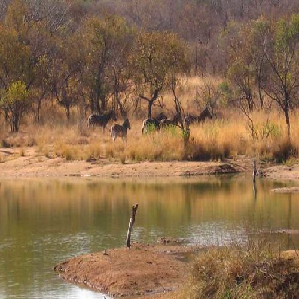

In [1141]:
idx = 8
this_img = image_list[idx]
img_path = os.path.join(concept_dir,this_img)
show_img = image.load_img(img_path, target_size=(299, 299))
show_img

In [1144]:
img = prep2(img_path)
img = np.expand_dims(img, axis=0)
preds = sess.run(endpoints_v3['prediction'], {endpoints_v3['input']: img})
dec = decode_predictions(preds,top=1000)
dec

[[('n09421951', 'sandbar', 0.18911481),
  ('n02504458', 'African_elephant', 0.17554253),
  ('n02408429', 'water_buffalo', 0.17061473),
  ('n02398521', 'hippopotamus', 0.052409016),
  ('n02002724', 'black_stork', 0.040134154),
  ('n09332890', 'lakeside', 0.039604664),
  ('n02422699', 'impala', 0.020712232),
  ('n02391049', 'zebra', 0.019138446),
  ('n01871265', 'tusker', 0.019025018),
  ('n02009229', 'little_blue_heron', 0.016011193),
  ('n02018795', 'bustard', 0.014454711),
  ('n02397096', 'warthog', 0.014080032),
  ('n02422106', 'hartebeest', 0.013516534),
  ('n01518878', 'ostrich', 0.011961146),
  ('n02486410', 'baboon', 0.009929529),
  ('n02009912', 'American_egret', 0.008946574),
  ('n02117135', 'hyena', 0.008287777),
  ('n01697457', 'African_crocodile', 0.0069243633),
  ('n02410509', 'bison', 0.006487441),
  ('n02011460', 'bittern', 0.00508644),
  ('n02012849', 'crane', 0.0047852867),
  ('n02423022', 'gazelle', 0.0047549964),
  ('n02504013', 'Indian_elephant', 0.0046608034),
  ('n

In [1149]:
z = None
for d in dec[0]:
    if d[1] =='zebra':
        z = d[2]

In [1150]:
z

0.019138446

In [1139]:
idx = 8
mag_1[idx]

-0.006329443903969419

In [1140]:
acts_p[idx].shape

(221952,)

In [1138]:
c[8]

0.18911481

In [1130]:
cosine_similarity(acts_p[idx],cav_1)

0.11725603960429555

In [1154]:
a,b,c = [],[],[]
for idx in range(50):
    a.append(cosine_similarity(acts_p[idx],cav_1))
    b.append(mag_1[idx])
    this_img = image_list[idx]
    img_path = os.path.join(concept_dir,this_img)
    img = prep2(img_path)
    img = np.expand_dims(img, axis=0)
    preds = sess.run(endpoints_v3['prediction'], {endpoints_v3['input']: img})
    dec = decode_predictions(preds,top=1000)
    z = None
    for d in dec[0]:
        if d[1] =='zebra':
            z = d[2]
    c.append(z)

In [1156]:
#c

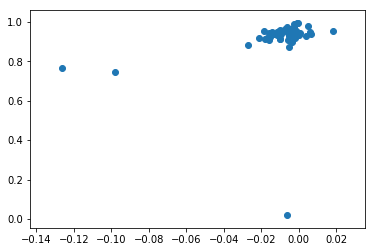

In [1157]:
plt.scatter(b,c)
#plt.ylim(.7, 1)

In [1068]:
#get_prediction(prep2(img_path))

In [1060]:
def get_prediction(img):
    img = preprocess_input(img)
    preds = sess.run(endpoints_v3['prediction'], {endpoints_v3['input']: img})
    top = decode_predictions(preds, top=3)
    return top

In [1073]:
mag_1

array([ 0.00602313, -0.01572166, -0.00496819, -0.09828524, -0.00567283,
       -0.00522405, -0.0014079 , -0.0117756 , -0.00632944,  0.00495949,
       -0.00606633, -0.02106742,  0.00015409, -0.00271102, -0.12633532,
       -0.00249213, -0.00963157, -0.00382968, -0.01319498, -0.00613036,
       -0.00731701, -0.00437327, -0.0101853 , -0.01789559,  0.00655529,
        0.01823633, -0.01076025, -0.01544237, -0.01077225, -0.00477432,
       -0.01689613, -0.0004119 , -0.00986992, -0.01184333, -0.01841058,
       -0.01592307, -0.01409973,  0.00379951, -0.00104761, -0.00998825,
       -0.00150009, -0.00912863,  0.00071724, -0.01017934, -0.0105346 ,
       -0.00373871, -0.00440908, -0.02701738, -0.01175346, -0.00188095])

In [1072]:
mag_2.argmax()

25

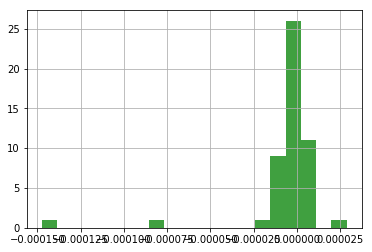

In [1022]:
#plt.xlim(-.02, .02)

n, bins, patches = plt.hist(mag_2, 20, facecolor='g', alpha=0.75)

#plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

In [966]:
mag_1.shape

(50,)

In [ ]:
target_class,cav_L1,acts_class,layer

In [1031]:
i = 0
act_at_idx = np.expand_dims(class_acts[i], 0)
this_mag = get_magnitude(act_at_idx,class_id,cav_L1,bottleneck_name)

In [1032]:
this_mag

-5.522488625572138e-05

In [1044]:
i = 0
act_at_idx = np.expand_dims(class_acts[i], 0)
dot,grads = get_magnitude_and_grad(act_at_idx,class_id,cav_1,bottleneck_name)

In [1045]:
dot

-0.043131165947886546

In [1046]:
grads.shape

(131072,)

In [1414]:
## Dim reduction

In [1463]:
## t-SNE

In [1570]:
layer = 'mixed9'
concepts = ['striped_sub_1','striped_sub_2','random500_0','random500_1','random500_2',
            'woven_sub_1','knitted_sub_1','horse_sub_1','grid_sub_1']
all_acts = None
colors = None
for idx,c in enumerate(concepts):
    my_acts,_ = get_acts_for_concept(c,layer)
    if all_acts is not None:
        all_acts = np.concatenate((all_acts,my_acts))
        colors = np.concatenate((colors,np.ones(50) * idx))
    else:
        all_acts = my_acts
        colors = np.ones(50) * idx

In [1571]:
#colors

In [1572]:
embed_colors = []
colors_list = ['blue','red','black','black','black','orange','yellow','brown','purple']
for c in colors:
    embed_colors .append(colors_list[int(c)])

In [1573]:
from sklearn.manifold import TSNE
import umap

In [1574]:
## TSNE
embed = TSNE(n_components=2, perplexity=50,).fit_transform(all_acts)

(-10, 10)

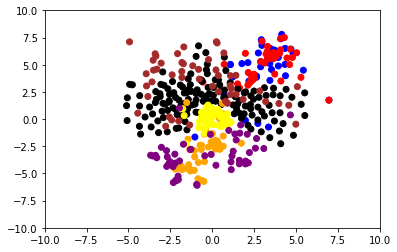

In [1576]:
plt.scatter(embed[:,0], embed[:,1], color = embed_colors)

ax_len = 10
plt.xlim([-ax_len,ax_len])
plt.ylim([-ax_len,ax_len])

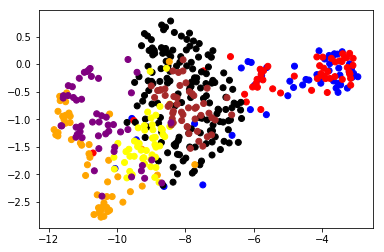

In [1577]:
## TSNE
this_umap = umap.UMAP(n_neighbors=30, random_state=42).fit(all_acts)

embed = this_umap.transform(all_acts)

#embed = TSNE(n_components=2, perplexity=50,).fit_transform(all_acts)
plt.scatter(embed[:,0], embed[:,1], color = embed_colors)

ax_len = 50
#plt.xlim([-ax_len,ax_len])
#plt.ylim([-ax_len,ax_len])

In [1554]:
from sklearn.decomposition import SparsePCA

In [1555]:
sPCA = SparsePCA(n_components=2,normalize_components=False,)

In [1594]:
layer = 'mixed9'

#my_class = 'zebra_50'
concept_p,concept_n = 'striped_sub_1','random500_0'
acts_p,_ = get_acts_for_concept(concept_p,layer)
acts_n,_ = get_acts_for_concept(concept_n,layer)
#_,acts_class = get_acts_for_concept(my_class,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(50),np.ones(50)))
idx_array = np.arange(100)

x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(x, y, idx_array, test_size=0.33, stratify=y,random_state=1,)

cav_1 = make_orig_cav(x_train,y_train)

In [1592]:
x.shape

(100, 131072)

In [1581]:
sPCA.fit(x_train)

SparsePCA(U_init=None, V_init=None, alpha=1, max_iter=1000, method='lars',
     n_components=2, n_jobs=None, normalize_components=False,
     random_state=None, ridge_alpha=0.01, tol=1e-08, verbose=False)

In [1586]:
train_embed.shape

(2, 67)

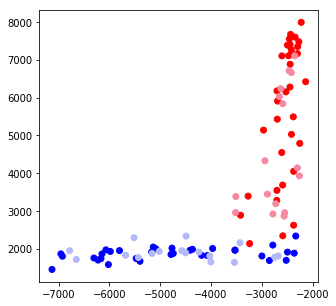

In [1682]:
sPCA_comps = sPCA.components_

train_embed = np.dot(sPCA_comps, x_train.T)
test_embed = np.dot(sPCA_comps, x_test.T)
c_train = ['red' if y == 0 else 'blue' for y in y_train]
c_test = [light_red if y == 0 else light_blue for y in y_test]

light_blue,light_red = '#b3b8fb','#f6889f'

fig = plt.figure(figsize=[5,5])

plt.scatter(train_embed[0], train_embed[1], color = c_train)
plt.scatter(test_embed[0], test_embed[1], color = c_test) #, alpha = .6)

#plt.xlim([-40,40])
#plt.ylim([-5,10])

In [1683]:
train_embed[1].argmin()

49

In [1685]:
#train_embed

In [1719]:
train_embed_p = train_embed.copy()
train_embed_n = train_embed.copy()
for i in range(67):
    if y_train[i] == 0:
        train_embed_n[:,i] = ('nan')
    else:
        train_embed_p[:,i] = ('nan')
        
test_embed_p = test_embed.copy()
test_embed_n = test_embed.copy()
for i in range(33):
    if y_test[i] == 0:
        test_embed_n[:,i] = ('nan')
    else:
        test_embed_p[:,i] = ('nan')

In [1688]:
#train_embed_n

In [1691]:
np.nanargmax(train_embed_n[1])

54

In [1697]:
train_embed_n[:,54]

array([-2330.12841673,  2333.82759219])

In [1732]:
np.where(train_embed_p[1] > 6000,)

/Users/tyler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


(array([ 0,  1,  8, 14, 22, 26, 30, 37, 39, 41, 46, 52, 53, 59, 62, 63, 64,
        66]),)

In [1708]:
train_embed_p[:,27]

array([-3417.42952765,  2884.45810644])

In [1737]:
idx_train[22]

23

In [1663]:
acts = []
for d in this_dict:
    acts.append(d)
acts_array = np.array(acts)

In [1700]:
image_list[13]

'ILSVRC2012_val_00013778.JPEG'

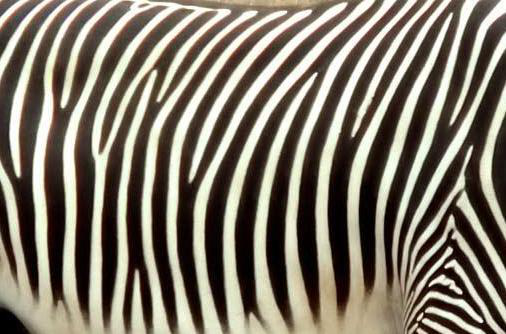

In [1738]:
this_idx = 23
concept = 'striped_sub_1'
#concept = 'random500_0'

act_path = os.path.join(working_dir,'final_acts/' + concept + '-' + layer + '.pkl')
this_dict = pickle.load(open(act_path, 'rb'))
image_list = [d for d in this_dict.keys()]

img_path = 'concepts/' + concept + '/'+ image_list[this_idx]
show_img = image.load_img(img_path)
show_img

In [ ]:
fig = plt.figure(figsize=[5,5])
circ = plt.Circle((-0, 0), radius=8, edgecolor='black', facecolor='None')
ax = plt.gca()

ax.add_patch(circ)
this_cav = cav_1
cav_pca = np.dot(sPCA_comps, this_cav.T)
cav_norm = vector_norm(cav_pca)
cav_norm *= 8
#origin = [-30],[30]
#plt.quiver(*origin, cav_norm[0], cav_norm[1], color='black',scale=100)

arrow_start = [-0,0]

my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None)
ax.add_patch(my_arrow)

ax_len = 10
plt.xlim([-ax_len,ax_len])
plt.ylim([-ax_len,ax_len])

In [1740]:
this_cav.shape

(131072,)

In [1741]:
## Classify Class Acts for TCAV score

In [2135]:
layer = 'mixed9'

my_class = 'lion'
concept_p,concept_n = 'striped_sub_1','random500_0'
acts_p,_ = get_acts_for_concept(concept_p,layer)
acts_n,_ = get_acts_for_concept(concept_n,layer)
acts_class_flat,acts_class = get_acts_for_concept(my_class,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(50),np.ones(50)))
idx_array = np.arange(100)

x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(x, y, idx_array, test_size=0.33, stratify=y,random_state=1,)



In [2136]:
lm = linear_model.SGDClassifier(alpha=.1,random_state=3)#,class_weight={ 0:10, 1:1 })

from sklearn.svm import SVC
svc = SVC(kernel = 'linear',probability=True)#,class_weight={ 0:.9, 1:.1 })
svc.fit(x_train, y_train)

lm.fit(x_train, y_train,)
cav_1 = -lm.coef_[0]

#cav_1 = make_orig_cav(x_train,y_train)
#score_1 = comp_tcav(my_class,cav_1,acts_class,layer)
#print(score_1)

In [2137]:
lm_preds = lm.predict(acts_class_flat)

In [2138]:
np.where(lm_preds==0)

(array([], dtype=int64),)

In [2139]:
svc.predict(acts_class_flat).sum()

50.0

In [2140]:
p0 = svc.predict_proba(acts_class_flat)[:,0]

In [2141]:
p0.max(),p0.min()

(0.06714417383962844, 0.004355210417278728)

In [2142]:
p0.argmax(),p0.argmin()

(27, 31)

In [2146]:
np.where(p0>.05)

(array([ 1,  6, 27, 42]),)

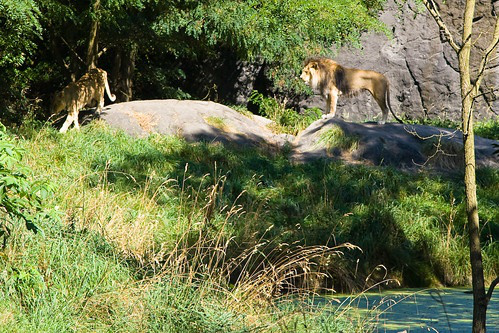

In [2149]:
this_idx = 42
concept = 'lion'
#concept = 'random500_0'

act_path = os.path.join(working_dir,'final_acts/' + concept + '-' + layer + '.pkl')
this_dict = pickle.load(open(act_pa`th, 'rb'))
image_list = [d for d in this_dict.keys()]

img_path = 'concepts/' + concept + '/'+ image_list[this_idx]
show_img = image.load_img(img_path)
show_img

In [2117]:
my_class = 'ceo'
acts_class_flat,acts_class = get_acts_for_concept(my_class,layer)

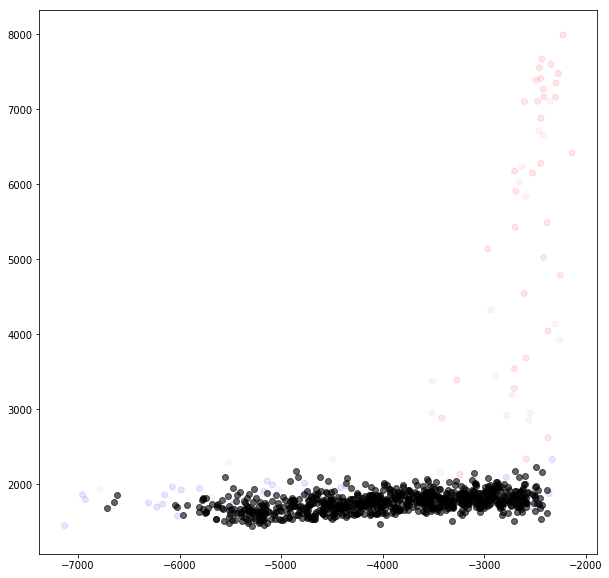

In [2118]:
sPCA_comps = sPCA.components_

train_embed = np.dot(sPCA_comps, x_train.T)
test_embed = np.dot(sPCA_comps, x_test.T)
c_train = ['red' if y == 0 else 'blue' for y in y_train]
c_test = [light_red if y == 0 else light_blue for y in y_test]

light_blue,light_red = '#b3b8fb','#f6889f'

fig = plt.figure(figsize=[10,10])

plt.scatter(train_embed[0], train_embed[1], color = c_train, alpha=.1)
plt.scatter(test_embed[0], test_embed[1], color = c_test, alpha=.1)

class_embed = np.dot(sPCA_comps, acts_class_flat.T)
plt.scatter(class_embed[0], class_embed[1], color = 'black', alpha=.6)


In [2098]:
.shape

(140, 131072)

In [1027]:
def comp_tcav(target_class,this_cav,class_acts,bottleneck_name):
    count = 0
    class_id = mymodel.label_to_id(target_class)

    for i in range(len(class_acts)):
        act_at_idx = np.expand_dims(class_acts[i], 0)
        if get_dir(act_at_idx,class_id,this_cav,bottleneck_name):
            count += 1
    return float(count) / float(len(class_acts))

def get_dir(acts, class_id, this_cav, bottleneck_name):
    grads = sess.run(mymodel.bottlenecks_gradients[bottleneck_name], 
                 {mymodel.bottlenecks_tensors[bottleneck_name]: acts,
                 mymodel.y_input: [class_id]})
                     
    grad = np.reshape(grads, -1)
    dot_prod = np.dot(grad, this_cav)

    return dot_prod < 0

def get_magnitude_list(target_class,this_cav,class_acts,bottleneck_name):
    class_id = mymodel.label_to_id(target_class)
    magnitude_list = []
    for i in range(len(class_acts)):
        act_at_idx = np.expand_dims(class_acts[i], 0)
        this_mag = get_magnitude(act_at_idx,class_id,this_cav,bottleneck_name)
        magnitude_list.append(this_mag)
    return np.array(magnitude_list)


def get_magnitude(acts, class_id, this_cav, bottleneck_name):
    grads = sess.run(mymodel.bottlenecks_gradients[bottleneck_name], 
                 {mymodel.bottlenecks_tensors[bottleneck_name]: acts,
                 mymodel.y_input: [class_id]})
                     
    grad = np.reshape(grads, -1)
    dot_prod = np.dot(grad, this_cav)

    return dot_prod

def get_magnitude_and_grad(acts, class_id, this_cav, bottleneck_name):
    grads = sess.run(mymodel.bottlenecks_gradients[bottleneck_name], 
                 {mymodel.bottlenecks_tensors[bottleneck_name]: acts,
                 mymodel.y_input: [class_id]})
                     
    grad = np.reshape(grads, -1)
    dot_prod = np.dot(grad, this_cav)

    return dot_prod,grad